# <center>Inteligencia Artificial</center>
#### <center>Profesor: Dr. Hernán D. Merlino </center>


## <center>Trabajo Práctico:</center>
### <center>  Generar chistes</center>


#### **Integrante:**

* Brayan Ricaldi

## Explicacion previa:

Utilizare el tipo de dato Arrow y no Pandas. Por los siguientes motivos:
   - Arrow esta diseñado para el procesamiento de datos de alto rendimiento y representa  cada conjunto de datos similar a una tabla con un formato en columna de memoria.
   - Permite multiplces procesos sin mover ni copiar los datos, estoo hace que iterar los datos sea realmente rapido.
   
Por estos motivos he podido crear mi modelo y estudiarlo, sin problemas de memoria.<br>
Para mas detalles: https://huggingface.co/course/chapter5/4?fw=pt.

Team Arrow!!

In [12]:
import transformers
import matplotlib.pyplot as plt
import seaborn as sns

2023-03-06 16:25:43.808052: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
#import torch
#device = 'cpu'
#if torch.cuda.is_available():
#    device = 'cuda'

## Descargando los datos

<p>Para este modelo usare 2 conjunto de datos.</p>
<p>Fuente:</p>
<ul>
    <li><b>ds_1</b>: https://www.kaggle.com/datasets/abhinavmoudgil95/short-jokes?resource=download</li>
</ul>

In [1]:
from datasets import load_dataset

In [2]:
ds = load_dataset(
                    "csv",
                    data_files="./DataSets/shortjokes.csv",
                    split="train"
                    )
ds

Using custom data configuration default-9313eabec7887a97
Found cached dataset csv (/home/br/.cache/huggingface/datasets/csv/default-9313eabec7887a97/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317)


Dataset({
    features: ['ID', 'Joke'],
    num_rows: 231657
})

In [3]:
#Formato usado: Apache Arrow
muestra = ds.shuffle(seed=0).select(range(2))

for i in muestra:
    print(f"\n>>> ID: {i['ID']}")
    print(f">>> Joke: {i['Joke']}")

Loading cached shuffled indices for dataset at /home/br/.cache/huggingface/datasets/csv/default-9313eabec7887a97/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317/cache-751734f7ad0b3d4e.arrow



>>> ID: 133560
>>> Joke: I'm not John Madden, just John Disappointeden.

>>> ID: 229327
>>> Joke: Scientists have recently discovered the existence of a mentally unstable microscopic parasite on the moon... Apparently it's a real lunatic


## Estudio del dataSet

Convierto el DataSet a formato pandas, para mejor estudio de los datos y visualizaciones.

In [4]:
import pandas as pd
df = ds.to_pandas()

<p><b>Busco la cantidad de None del dataSet</b></p>

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 231657 entries, 0 to 231656
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   ID      231657 non-null  int64 
 1   Joke    231657 non-null  object
dtypes: int64(1), object(1)
memory usage: 3.5+ MB


Observo que el dataSet no tiene ningun None, en otras palabras no tiene ningun dato faltante.

<p><b>Busco la cantidad de datos repetidos</b></p>

In [6]:
print(f" Cantidad de datos repetidos: {sum(df.duplicated(keep='first'))}")

 Cantidad de datos repetidos: 0


No tengo ningun dato repetido.

<p><b>Estudio la longitud de los chistes</b></p>

Ahora voy a estudiar la longitud de los chistes, el separador sera el espacio(" ").<br>
La longitud de cada chiste se consegira con el dataSet tipo Arrow para optimizar la velocidad y la ram.

In [8]:
def longitud(chiste):
    return {"joke_len": len(chiste["Joke"].split())}

In [9]:
ds = ds.map(longitud)

  0%|          | 0/231657 [00:00<?, ?ex/s]

In [10]:
df = ds.to_pandas()
df.head()

,ID,Joke,joke_len
0,1,"[me narrating a documentary about narrators] ""...",15
1,2,Telling my daughter garlic is good for you. Go...,18
2,3,I've been going through a really rough period ...,23
3,4,"If I could have dinner with anyone, dead or al...",16
4,5,Two guys walk into a bar. The third guy ducks.,10


Text(0.5, 1.0, 'Longitud de los chistes')

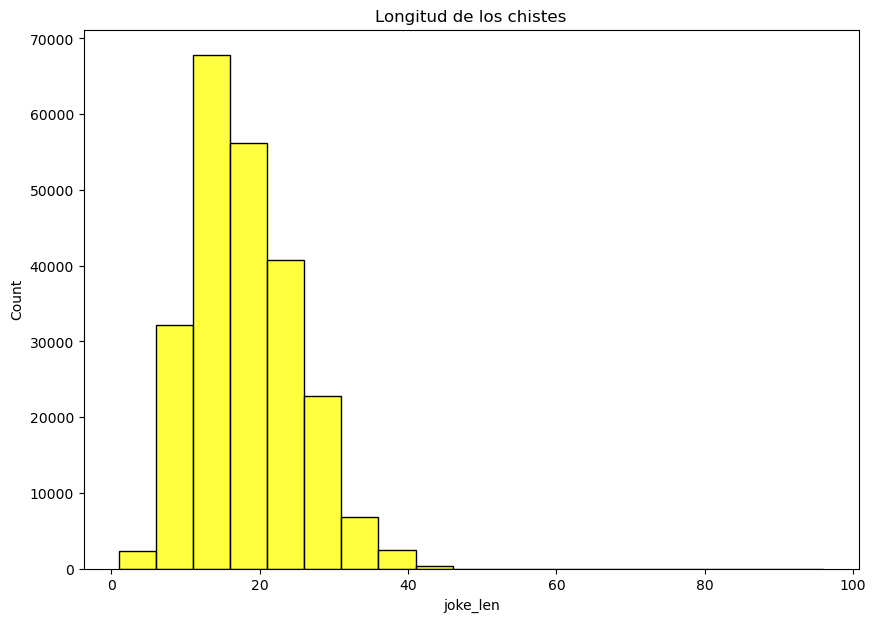

In [13]:
fig, axes = plt.subplots(nrows=1, ncols=1, dpi=100, figsize=(10, 7))
sns.histplot(
    x="joke_len",
    data=df,
    binwidth=5,
    color="#ffff00",
)
axes.set_title("Longitud de los chistes")

Observo que hay chistes de longitud menor a 5.

In [25]:
longitud_minima_chistes = 5

In [26]:
df[df["joke_len"] < longitud_minima_chistes]

,ID,Joke,joke_len
38,39,Ted Cruz getting elected.,4
480,481,Political Joke The Economy,4
617,618,Broken pencils... ...are pointless.,4
668,669,Prostitutes hate trick-or-treaters.,3
671,672,The definition of spin,4
...,...,...,...
231147,231148,Obamacare.,1
231372,231373,Evolution: True science fiction.,4
231473,231474,Jesus Saves.... Moses invests.,4
231550,231551,Strap-on backwards spells No-parts.,4


Me doy cuenta que si son algo chistosos por ejemplo los chistes:
   - Canada's navy. ("La marina de Canada") #ID = 231575
   - Ted Cruz getting elected. ("Ted Cruz siendo elegido") #ID = 39

In [16]:
chistes_menores_cinco = df[df["joke_len"] < longitud_minima_chistes].shape[0]
chistes_total = df.shape[0]
print(f"Porcentaje del total de chistes menores a 5: {(100 * chistes_menores_cinco) / chistes_total}%")


Porcentaje del total de chistes menores a 5: 0.49901362790677595%


<p>Observo que si los elimino perderia menos de 1% de mi dataSet.</p>
<p>Optare por no eliminarlos.</p>

## Preparando los dataSet

Elimino el feature ID porque no brinda informacion

In [27]:
ds = ds.remove_columns(["joke_len", "ID"])
ds

Dataset({
    features: ['Joke'],
    num_rows: 231657
})

Cambio el nombre del feature "Joke" por "joke", por comodidad

In [28]:
ds = ds.rename_column("Joke", "joke")
ds

Dataset({
    features: ['joke'],
    num_rows: 231657
})

Elimino las etiquetas HTML de los chistes

In [29]:
import html
ds = ds.map(lambda x: {"joke": html.unescape(x["joke"])})
ds

  0%|          | 0/231657 [00:00<?, ?ex/s]

Dataset({
    features: ['joke'],
    num_rows: 231657
})

## Dividio el dataSet en train y test

Divido el dataSet en 2:
   - Train: 70%.
   - Test: 30%. <br>

Para division sera de forma aleatoria con el parametro shuffle=True.

In [32]:
ds_joke = ds.train_test_split(
                                test_size=0.3, 
                                shuffle=True,
                                seed=1
                            )

In [33]:
ds_joke

DatasetDict({
    train: Dataset({
        features: ['joke'],
        num_rows: 149330
    })
    test: Dataset({
        features: ['joke'],
        num_rows: 63999
    })
})

# Modelo

## Tokenizacion

In [34]:
from transformers import AutoTokenizer

La longitud de los contextos sera de 128, por temas de optimizar la memoria.<br>
Si tiene una memoria mayor y un cpu potente lo puede cambiar por 1024 o 2048.

In [35]:
context_length = 32

Longitud del contexto: Cantidad de tokens que debe tener la oracion. <br>
#Importante: AGREGAR IMAGEN DE EXPLICACION.

Descargo un tokenizador ya entrenado.<br>
Cada token ya tiene establecido su propio ID <br>
#IMPORTANTE: AGREGAR IMAGEN EXPLICANDO ESTE PROCESO

In [36]:
tokenizer = AutoTokenizer.from_pretrained("huggingface-course/code-search-net-tokenizer")

In [37]:
def tokenize_function(examples):
    outputs = tokenizer(
        examples["joke"], 
        truncation=False,#True
        return_overflowing_tokens=True,
        return_length=True,
        add_special_tokens=True,
        max_length=context_length,
    )
    
    input_batch = []
    for length, input_ids in zip(outputs["length"], outputs["input_ids"]):
        input_batch.append(input_ids + [tokenizer.eos_token_id])
        #if length == 15:
        #input_batch.append(input_ids)
    return {"input_ids": input_batch}



# Use batched=True to activate fast multithreading!
tokenized_datasets = ds_joke.map(
    tokenize_function, batched=True, remove_columns=ds_joke["train"].column_names)
tokenized_datasets

Map:   0%|          | 0/149330 [00:00<?, ? examples/s]

Map:   0%|          | 0/63999 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['input_ids'],
        num_rows: 149330
    })
    test: Dataset({
        features: ['input_ids'],
        num_rows: 63999
    })
})

Voy a estudiar la longitud de los tokens.

Imprimo la cantidad de tokens de los 15 1eros chistes.

In [38]:
tokenized_samples = tokenized_datasets["train"][:15]

for idx, sample in enumerate(tokenized_samples["input_ids"]):
    print(f"'>>> Review {idx} length: {len(sample)}'")

'>>> Review 0 length: 16'
'>>> Review 1 length: 16'
'>>> Review 2 length: 19'
'>>> Review 3 length: 29'
'>>> Review 4 length: 20'
'>>> Review 5 length: 16'
'>>> Review 6 length: 19'
'>>> Review 7 length: 22'
'>>> Review 8 length: 44'
'>>> Review 9 length: 26'
'>>> Review 10 length: 21'
'>>> Review 11 length: 42'
'>>> Review 12 length: 19'
'>>> Review 13 length: 37'
'>>> Review 14 length: 20'


Como se menciono anteriormente, voy a trabajar con un contexto de 128 tokens, asi que debo hacer que cada chiste tenga 128 tokens ni mas ni menos.<br>
Pero eso es un problema, ya que estamos observando que los 1eros 15 chistes estan compuestos por menos de 65 tokens.<br>

<h3><b>¿Que se podra hacer? </b></h3>
<p>Tenemos 4 posibles soluciones:<p>
<ol>
   <li> Solo quedarnos con los chistes formados por 128 tokens.</li>
   <li> Solo quedarnos con los chistes mayores o igual a 128 tokens, y luego truncar su valores(solo quedarme con los 1ero 128 tokens).</li>
   <li> Modificiar la longitud del contexto, un valor menor como ya vimos que los 1eros 15 chistes son de una longitud muy menor a 128, podemos cambiar el contexto a 20.
   <li> Concatenar todos los chistes y luego dividirlo en segmentos de 128 tokens.
</ol>
<p><b>Problemas:</b></p>
<ul>
    <li> Las soluciones 1 y 2 no serian las mas convenientes para nuestro problema, ya vimos que los 1eros 15 chistes eran menores a 128 tokens, perderiamos muchos datos al solo quedarme con los chistes largos.
    <li> Con la solucion 3 no perderia datos pero si contexto en los chistes, al solo quedarme con la parte inicial los chistes perderian significado.
    <li> La solucion 4 es la mejor. Ahora se explicara el <b>porque</b>.
</ul>


#IMPORTANTE: COMPLETAR <br>
Explicacion:

In [39]:
concatenated_examples = {
    k: sum(tokenized_samples[k], []) for k in tokenized_samples.keys()
}
total_length = len(concatenated_examples["input_ids"])
print(f"'>>> Concatenated reviews length: {total_length}'")

'>>> Concatenated reviews length: 366'


In [40]:
chunk_size = context_length

Una forma sencilla seria unir los tokens

In [41]:
chunks = {
    k: [t[i : i + chunk_size] for i in range(0, total_length, chunk_size)]
    for k, t in concatenated_examples.items()
}

for chunk in chunks["input_ids"]:
    print(f"'>>> Chunk length: {len(chunk)}'")

'>>> Chunk length: 32'
'>>> Chunk length: 32'
'>>> Chunk length: 32'
'>>> Chunk length: 32'
'>>> Chunk length: 32'
'>>> Chunk length: 32'
'>>> Chunk length: 32'
'>>> Chunk length: 32'
'>>> Chunk length: 32'
'>>> Chunk length: 32'
'>>> Chunk length: 32'
'>>> Chunk length: 14'


<p> Observo que el ultimo dato, tiene 87 tokens. </p>
<p>Tenemos 2 posibles soluciones.</p>
<ol>
    <li> Completar el dato con id que significan "vacio", para Arrow el 0 es el id vacio</li>
    <li> ELiminar el dato</li>
</ol>
<p>En este caso se elegira la opcion 2.</p>

Ahora recreare todo lo hecho con el dataSet completo.

In [42]:
def group_texts(examples):
    # Concateno todo el texto
    concatenated_examples = {k: sum(examples[k], []) for k in examples.keys()}
    # Calculo la longitud de los textos concatenados
    total_length = len(concatenated_examples[list(examples.keys())[0]])
    # Si el ultimo fragmento es mas pequenio que la "longitud del contexto" sera eliminado.
    total_length = (total_length // chunk_size) * chunk_size
    # Hago un split del tamanio de la "longitud del contexto"
    result = {
        k: [t[i : i + chunk_size] for i in range(0, total_length, chunk_size)]
        for k, t in concatenated_examples.items()
    }
    return result

In [43]:
df_tokenizado = tokenized_datasets.map(group_texts, batched=True)
df_tokenizado

Map:   0%|          | 0/149330 [00:00<?, ? examples/s]

Map:   0%|          | 0/63999 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['input_ids'],
        num_rows: 122550
    })
    test: Dataset({
        features: ['input_ids'],
        num_rows: 52514
    })
})

<h3>¿Por que la solucion 4 funciona?</h3>

<p>No solo se concatenara los chistes, sino tambien nuestro modelo gpt2(Spolier!) se dara cuenta que cada data no es un solo chiste, sino que pueden ser varios y los tomara por separado</p>
<p><b>Y como se da cuenta cuando termina uno y comienza el siguiente chistes?</b></p>
<p>Por el caracter especial del tokenizador eos_token, que fue agregado cuando tokenizamos en el siguiente codigo:</p>
<ul>
    <li>input_batch.append(input_ids + <b>[tokenizer.eos_token_id]</b>)</li>
</ul>
</p>Su representacion es de la siguiente forma:</p>
<ul>
    <li>>>> Texto: <|endoftext|> </li>
    <li>>>> ID: 0</li>
</ul>

Lo vamos a observar en nuestro 1er dato

In [44]:
tokenizer.decode(df_tokenizado["train"][0]["input_ids"])

"It's a fetish I never knew I had until now.<|endoftext|>What did the earthquake say to the tornado? It's not my fault.<|endoftext|>"

In [45]:
ids = list(df_tokenizado["train"][0]["input_ids"])
i_cero = [i for i, dato in enumerate(ids) if dato == 0]
print(f"Ids del 1er dato: {ids}")
print(f"Posiciones del 0: {i_cero}")

Ids del 1er dato: [9721, 975, 231, 242, 444, 5898, 410, 6388, 738, 1168, 410, 8690, 3445, 2498, 14, 0, 25027, 4620, 256, 32374, 12846, 292, 256, 11742, 31, 2296, 975, 339, 2673, 12389, 14, 0]
Posiciones del 0: [15, 31]


Observamos que en nuestro 1er dato hay 5 ceros, en otras palabras hay 4 chistes(no necesariamente el 1er y el ultimo esten completos).

# Modelo

<p>Inicializo un nuevo modelo de GPT2, con las configuracion que estoy usando.</p>
<ul>
    <li> La longitud de contexto en 64.</li>
    <li> La longitud del vocabulario igual al tokenizador. </li>
    <li> La separacion de los chistes con eos_token_id.</li>
</ul>

In [46]:
from transformers import AutoTokenizer, GPT2LMHeadModel, AutoConfig

config = AutoConfig.from_pretrained(
    "gpt2",
    vocab_size=len(tokenizer),
    n_ctx=context_length,
    bos_token_id=tokenizer.bos_token_id,
    eos_token_id=tokenizer.eos_token_id,
)
model = GPT2LMHeadModel(config)

Observo los parametros a entrenar de mi modelo.

In [47]:
model_size = sum(t.numel() for t in model.parameters())
print(f"GPT-2 size: {model_size/1000**2:.1f}M parametros")

GPT-2 size: 124.2M parametros


In [48]:
#IMPORTANTE: Al tener todas las filas de 128 tokens, no es necesario el recolector de datos!

In [49]:
from transformers import DataCollatorForLanguageModeling 

tokenizer.pad_token = tokenizer.eos_token 
data_collator = DataCollatorForLanguageModeling(tokenizer, 
                                                mlm= False # True: Si es para un modelo de lenguaje enmascarado  
                                               )

In [50]:
from transformers import DataCollatorForLanguageModeling

tokenizer.pad_token = tokenizer.eos_token
data_collator = DataCollatorForLanguageModeling(tokenizer, mlm=False)

In [51]:
out = data_collator([tokenized_datasets["train"][i] for i in range(5)])
for key in out:
    print(f"{key} shape: {out[key].shape}")

You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


input_ids shape: torch.Size([5, 29])
attention_mask shape: torch.Size([5, 29])
labels shape: torch.Size([5, 29])


In [52]:
from huggingface_hub import notebook_login

notebook_login()

In [53]:
import torch
print(f"Is Cuda available: {torch.cuda.is_available()}")
print(f"CUDA device: {torch.cuda.get_device_name(torch.cuda.current_device)}")

Is Cuda available: True
CUDA device: NVIDIA GeForce RTX 3050 Ti Laptop GPU


In [ ]:
from transformers import Trainer, TrainingArguments

args = TrainingArguments(
    output_dir="br_CLM",
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    evaluation_strategy="steps",
    eval_steps=5_000,
    logging_steps=5_000,
    gradient_accumulation_steps=8,
    num_train_epochs=1,
    weight_decay=0.1,
    warmup_steps=1_000,
    lr_scheduler_type="cosine",
    learning_rate=5e-4,
    save_steps=5_000,
    fp16=True, #Importante: SOlo descomentar si tenes GPU
    push_to_hub=True,
)

trainer = Trainer(
    model=model,
    tokenizer=tokenizer,
    args=args,
    data_collator=data_collator,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["test"],
)

C:\Users\brar2\OneDrive\Escritorio\Archivos\FIUBA\IA\br_CLM is already a clone of https://huggingface.co/Br22/br_CLM. Make sure you pull the latest changes with `repo.git_pull()`.


In [ ]:
trainer.train()

# Datos 2

In [ ]:
df_2 = load_dataset("json", data_files="./DataSets/reddit_jokes.json", split="train")

In [ ]:
df_2

In [ ]:
df_2[0:4]

In [ ]:
df_2

In [ ]:
df_2 = df_2.remove_columns(["score", "title", "id"])

In [ ]:
df_2[0]

In [ ]:
len(df_2)

In [ ]:
df_2[-1]